In [1]:
import os
adir = '../../../data/ExVivo/Seqwell/'
project_name = 'exvivo2_20200318_mmul8_V4'
gcs = False

results_dir = '../../../results'

abase = os.path.join(adir, project_name)
abase

'../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../Code')
from utils import save_adata, read_adata

import palettable
from IPython.display import display

from joblib import parallel_backend
from scipy.stats import ranksums
from harmony import harmonize
from statsmodels.stats.multitest import multipletests

import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(scanpy=True, dpi=80, vector_friendly=False, ipython_format='png')

np.random.seed(10)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


<a id=Check_No_duplicates></a>
## Doublecheck no duplicate samples


In [5]:
results_raw_file = os.path.join(adir, project_name + '_raw.h5ad')
print(results_raw_file)

../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4_raw.h5ad


In [6]:
adata = read_adata(results_raw_file, gcs=gcs)

In [7]:
adata.obs.columns

Index(['batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI',
       'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes',
       'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES'],
      dtype='object')

In [8]:
adata.obs.head()

,batch,array_id,run,BP,treatment_full,treatment,MOI,animal,hour,condition,sample,n_counts,n_genes,log_count,PCT_USABLE_BASES,PCT_MRNA_BASES
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAAAAAA,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,EV0003.irrad.H004,470.0,387,2.672098,0.016649,0.021162
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,EV0003.irrad.H004,3739.0,1629,3.572755,0.506396,0.522808
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAGGTGTA,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,EV0003.irrad.H004,1615.0,801,3.208173,0.485782,0.495108
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAGCCCAGC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,EV0003.irrad.H004,903.0,572,2.955688,0.446060,0.464669
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACAACATTT,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,EV0003.irrad.H004,1324.0,657,3.121888,0.494924,0.513192


In [9]:
adata.obs['run'].value_counts()

Novaseq_20190829    115138
Name: run, dtype: int64

In [10]:
adata.obs['hour'].value_counts()

H004    57579
H024    57559
Name: hour, dtype: int64

In [11]:
adata.obs['condition'].value_counts()

live.H004     38385
live.H024     38365
irrad.H004     9599
media.H024     9597
irrad.H024     9597
media.H004     9595
Name: condition, dtype: int64

In [12]:
adata.obs['animal'].value_counts()

EV0003    57579
EV0004    57559
Name: animal, dtype: int64

In [13]:
adata.obs['treatment_full'].value_counts()

live-moi1e-1     76750
irrad-moi1e-1    19196
media            19192
Name: treatment_full, dtype: int64

In [14]:
adata.obs['batch'].value_counts()

EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829    4800
EV0004.H024.fresh.a2.std.EX2.live-moi1e-1_88_Novaseq_20190829     4800
EV0004.H024.fresh.a1.std.EX2.media_88_Novaseq_20190829            4800
EV0003.H004.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829     4800
EV0003.H004.fresh.a3.std.EX2.live-moi1e-1_88_Novaseq_20190829     4800
EV0004.H004.fresh.a2.std.EX2.live-moi1e-1_88_Novaseq_20190829     4800
EV0003.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829     4800
EV0004.H004.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829     4800
EV0004.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829    4799
EV0003.H004.fresh.a1.std.EX2.media_88_Novaseq_20190829            4799
EV0003.H004.fresh.a2.std.EX2.live-moi1e-1_88_Novaseq_20190829     4799
EV0003.H024.fresh.a4.std.EX2.live-moi1e-1_88_Novaseq_20190829     4799
EV0004.H024.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829    4799
EV0004.H024.fresh.a1.std.EX2.live-moi1e-1_88_Novaseq_20190829     4799
EV0003

<a id="Basic_filters"></a>
## 2. Filter by min genes, % mito, % unusabe reads

In [15]:
adata = adata.copy()

In [16]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_genes(adata, min_cells=0)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


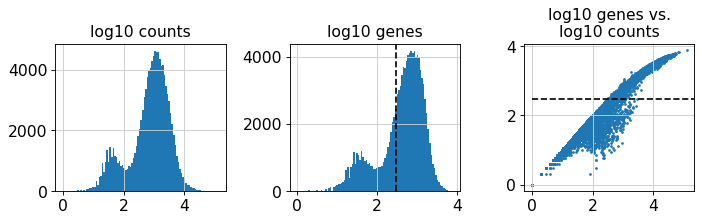

In [17]:
logncounts = adata.obs['n_counts'].apply(np.log10)
logngenes = adata.obs['n_genes'].apply(np.log10)

(fig,axes)= plt.subplots(1,3, figsize=(9,3))
axes[0].hist(logncounts,bins=100)
axes[1].hist(logngenes,bins=100)
axes[2].scatter(logncounts,logngenes, s=2)

ylim = axes[0].get_ylim()
axes[0].vlines(x=np.log10(count_thresh),ymin=0,ymax=ylim[1], linestyle='--')
axes[0].set_ylim(ylim)

ylim = axes[1].get_ylim()
axes[1].vlines(x=np.log10(gene_thresh),ymin=0,ymax=ylim[1], linestyle='--')
axes[1].set_ylim(ylim)

ylim = axes[2].get_ylim()
xlim = axes[2].get_xlim()
axes[2].vlines(x=np.log10(count_thresh),ymin=0,ymax=ylim[1], linestyle='--')
axes[2].hlines(y=np.log10(gene_thresh),xmin=0,xmax=xlim[1], linestyle='--')
axes[2].set_ylim(ylim)
axes[2].set_xlim(xlim)


axes[0].set_title('log10 counts')
axes[1].set_title('log10 genes')
axes[2].set_title('log10 genes vs.\nlog10 counts')
plt.tight_layout()

In [18]:
adata.shape

(115138, 23946)

In [19]:
sc.pp.filter_cells(adata, min_genes=gene_thresh)
sc.pp.filter_cells(adata, min_counts=count_thresh)
sc.pp.filter_genes(adata, min_cells=10)

filtered out 35863 cells that haveless than 300 genes expressed
filtered out 6919 genes that are detectedin less than 10 cells


In [20]:
adata

AnnData object with n_obs × n_vars = 79275 × 17027 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells'

In [21]:
ebov_genes = adata.var.index[adata.var['gene_id'].apply(lambda x: 'EBOV' in x)]

adata.obs['EBOV_counts'] = np.sum(
    adata[:, ebov_genes].X, axis=1).A1


adata.obs['num_EBOV_genes'] = np.sum(
    adata[:, ebov_genes].X>0, axis=1).A1
# add the total counts per cell as observations-annotation to adata

adata.obs['percent_EBOV'] = adata.obs['EBOV_counts'] / adata.obs['n_counts']
adata.obs['EBOV_TPT'] = (adata.obs['EBOV_counts'] / adata.obs['n_counts']) * 10000
adata.obs['log10_EBOV_TPT'] = (adata.obs['EBOV_TPT']+1).apply(np.log10)

In [22]:
gtf = pd.read_csv('gs://seqwell/data/references/Rhesus_Ebola_dropSeqPipe_v4/MmulKitwit_8_92/annotation.gtf', sep='\t', header=None)
gtf[0] = gtf[0].astype(str)
gtf.head()

mito_genes = list(gtf.loc[gtf[0]=='MT',8].apply(lambda x: re.findall('gene_name "(.+?)";', x)[0]).unique())
mito_genes = [x.split('__')[1] for x in mito_genes]
mito_genes = list(set(mito_genes).intersection(set(adata.var['gene_symbol'])))

adata.obs['percent_mito'] = np.sum( 
    adata[:, mito_genes].X, axis=1).A1 / adata.obs['n_counts'].values


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(0.0, 6329.4)

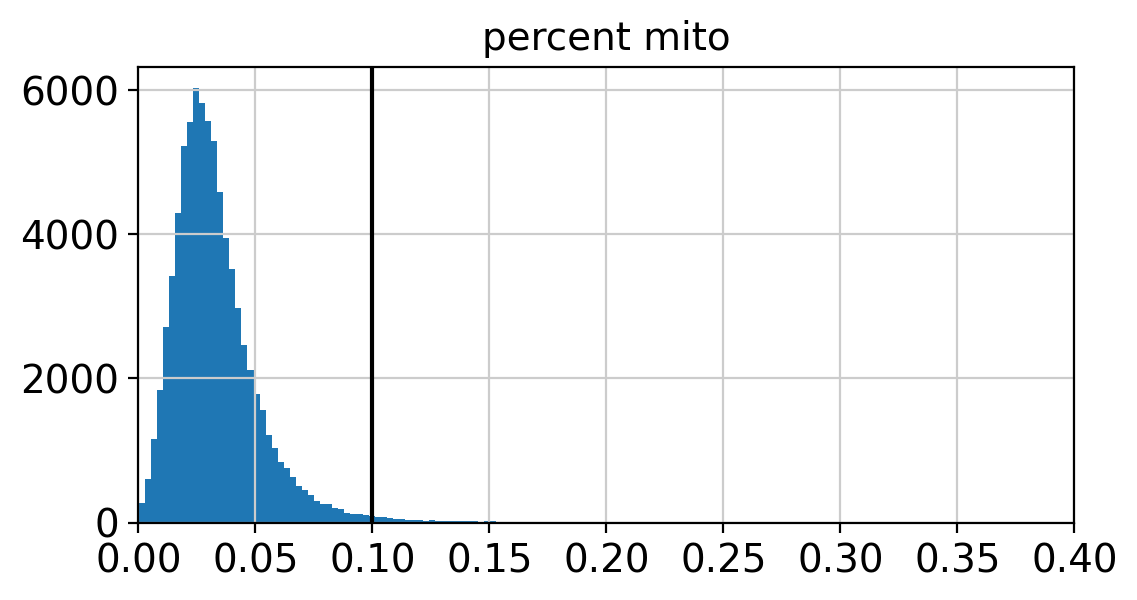

In [23]:
(fig,ax) = plt.subplots(1,1, figsize=(6,3), dpi=200)
ax.hist(adata.obs['percent_mito'], bins=200)
ax.set_title('percent mito')
ax.set_xlim([0,.4])
ylim = ax.get_ylim()
ax.vlines(x=mitothresh, ymin=ylim[0], ymax=ylim[1])
ax.set_ylim(ylim)

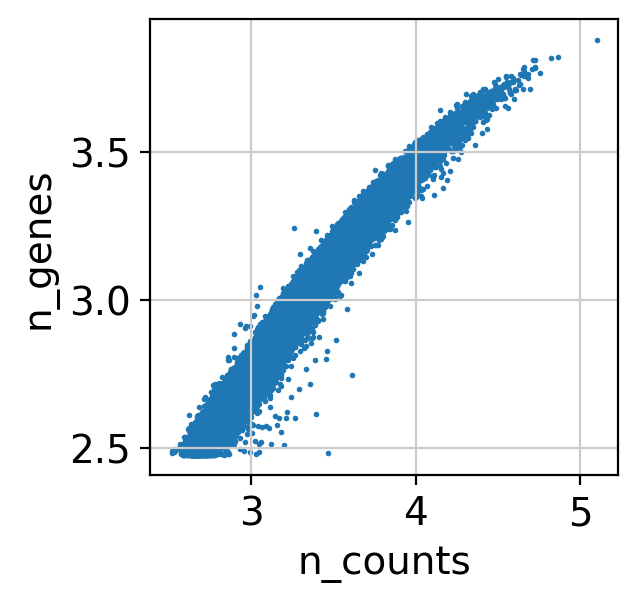

In [24]:
ngenethresh=5000
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(adata.obs['n_counts'].apply(np.log10),adata.obs['n_genes'].apply(np.log10), s=1)
ax.set_xlabel('n_counts')
ax.set_ylabel('n_genes')

xlim = ax.get_xlim()
#ax.hlines(y=np.log10(ngenethresh), xmin=xlim[0], xmax=xlim[1])
#ax.set_xlim(xlim)

In [25]:
(adata.obs['n_genes']>ngenethresh).sum(), (adata.obs['n_genes']>ngenethresh).mean()

(76, 0.0009586881110059918)

In [26]:
(adata.obs['percent_mito']>mitothresh).sum(), (adata.obs['percent_mito']>mitothresh).mean()

(919, 0.011592557552822454)

In [27]:
adata.obs['PCT_UNUSABLE_BASES'] = 1 - adata.obs['PCT_USABLE_BASES']

In [28]:
adata

AnnData object with n_obs × n_vars = 79275 × 17027 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells'

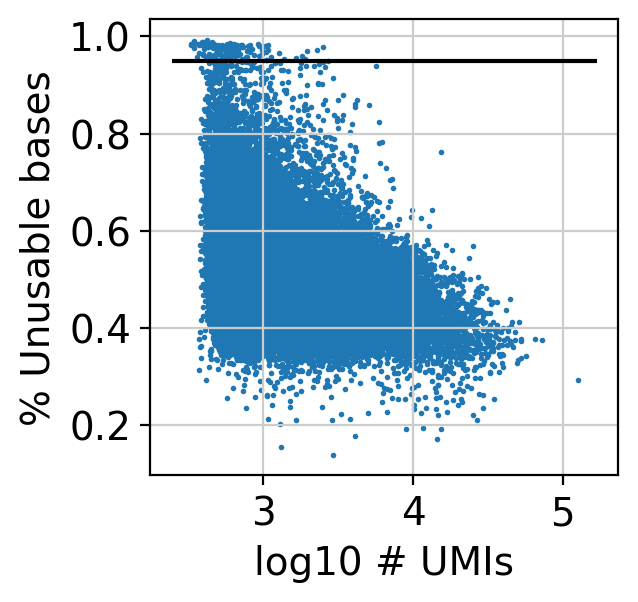

In [29]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(adata.obs['log_count'], adata.obs['PCT_UNUSABLE_BASES'], s=1)
ax.set_ylabel('% Unusable bases')
ax.set_xlabel('log10 # UMIs')
frac_unusable_thresh=.95
ax.hlines(y=frac_unusable_thresh, xmin=xlim[0], xmax=xlim[1])


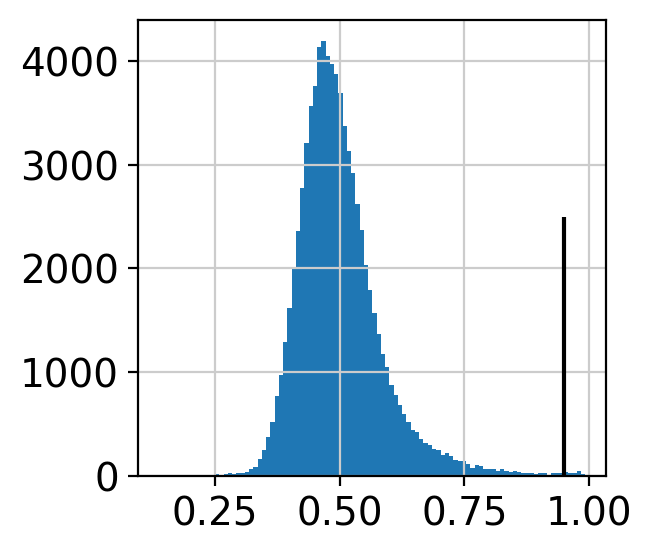

In [30]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
_ = ax.hist(adata.obs['PCT_UNUSABLE_BASES'], bins=100)
ax.vlines(x=frac_unusable_thresh, ymin=0, ymax=2500)


In [31]:
adata = adata[adata.obs['percent_mito'] < mitothresh, :]
adata = adata[adata.obs['PCT_UNUSABLE_BASES'] < frac_unusable_thresh, :]

In [32]:
adata

View of AnnData object with n_obs × n_vars = 78211 × 17027 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells'

In [33]:
hbb_genes = ['HBB']
adata.obs['percent_hbb'] = np.array(adata[:, 'HBB'].X.todense()).reshape(-1) / adata.obs['n_counts'].values


Trying to set attribute `.obs` of view, copying.


Text(0.5, 0, 'percent_hbb')

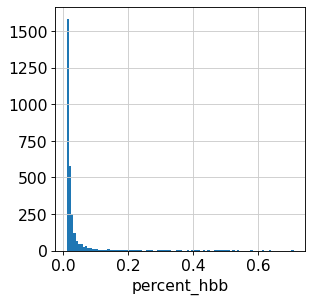

In [34]:
percent_hbb = adata.obs['percent_hbb']
_ = plt.hist(percent_hbb.loc[percent_hbb>.01], bins=100)
plt.xlabel('percent_hbb')

In [35]:
(adata.obs['percent_hbb']<=.1).value_counts()

True     78058
False      153
Name: percent_hbb, dtype: int64

In [36]:
adata = adata[adata.obs['percent_hbb']<=.1, :]

In [37]:
sc.pp.filter_genes(adata, min_cells=10)

filtered out 287 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


In [38]:
results_prefilt = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh))
print(results_prefilt)


../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.h5ad


In [39]:
save_adata(adata, results_prefilt, gcs=gcs)

Only considering the two last: ['.1', '.h5ad'].
Only considering the two last: ['.1', '.h5ad'].


## Run initial clustering

In [40]:
combined_blacklist_fn = '../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.blacklist.COMBINED.txt'
blacklist_genes = open(combined_blacklist_fn, 'r').read().split('\n')

cc_blacklist_fn = '../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.blacklist.CellCycle.txt'
cc_genes = open(cc_blacklist_fn, 'r').read().split('\n')

In [41]:
adata.var['Combined_Blacklist'] = adata.var.index.isin(blacklist_genes)
adata.var['CC_Blacklist'] = adata.var.index.isin(cc_genes)

In [42]:
adata.raw = adata.copy()

In [43]:
results_prefilt = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh))
print(results_prefilt)


../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.h5ad


In [44]:
save_adata(adata, results_prefilt, gcs=gcs)

Only considering the two last: ['.1', '.h5ad'].
Only considering the two last: ['.1', '.h5ad'].


In [45]:
adata = read_adata(results_prefilt, gcs=gcs)

Only considering the two last: ['.1', '.h5ad'].
Only considering the two last: ['.1', '.h5ad'].


In [46]:
sc.pp.filter_genes(adata, min_cells=10)
adata = adata[:,~(adata.var['Combined_Blacklist'] | adata.var['CC_Blacklist'])]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=nhvgs)
adata.var['highly_variable'].value_counts()

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:07): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


False    14290
True      2166
Name: highly_variable, dtype: int64

In [47]:
sc.pp.scale(adata, max_value=10)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:11)


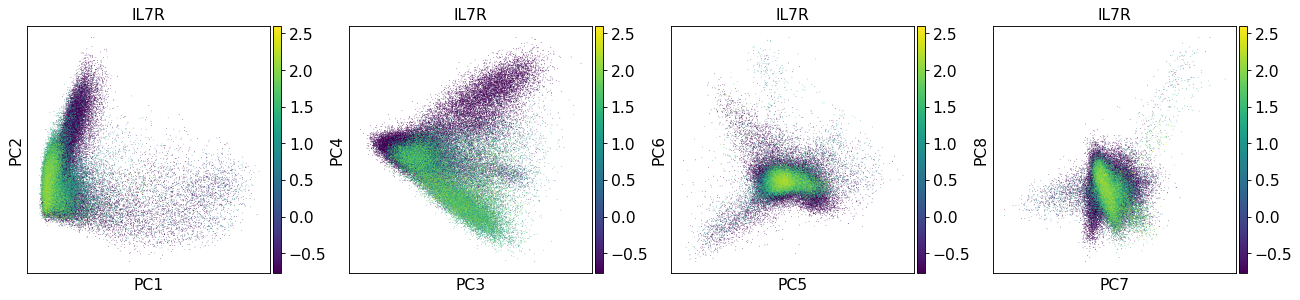

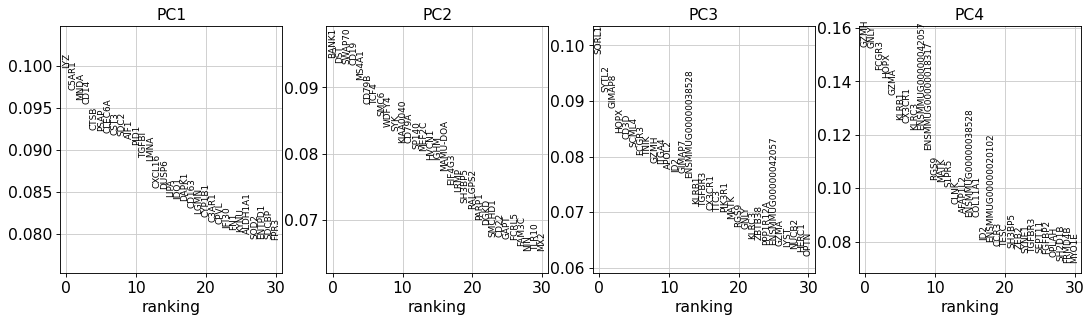

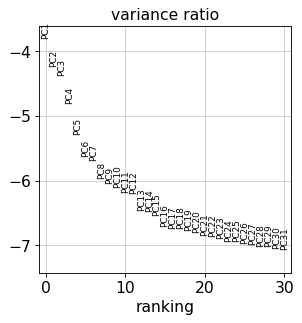

In [48]:
sc.tl.pca(adata, svd_solver='arpack', random_state=14, use_highly_variable=True)

sc.pl.pca(adata, components=['1,2', '3,4', '5,6', '7,8'], color=['IL7R'],
          ncols=4, use_raw=False)

sc.pl.pca_loadings(adata, components=[1,2,3,4])

sc.pl.pca_variance_ratio(adata, log=True)


In [49]:
with parallel_backend('threading', n_jobs=7):
    sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.001), n_pcs=16, random_state=14)
    
with parallel_backend('threading', n_jobs=7):
    sc.tl.umap(adata, min_dist=0.1, spread=2.0, random_state=14)

computing neighbors
    using 'X_pca' with n_pcs = 16


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:35)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:23)


In [50]:
adata.obs.columns

Index(['batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI',
       'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes',
       'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts',
       'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT',
       'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb'],
      dtype='object')

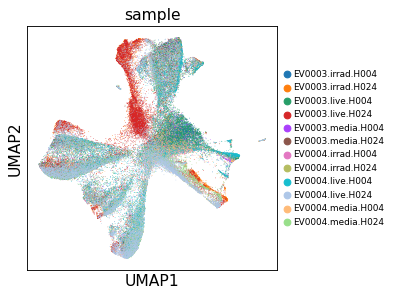

In [51]:
sc.pl.umap(adata, color=['sample'], legend_fontsize=8)

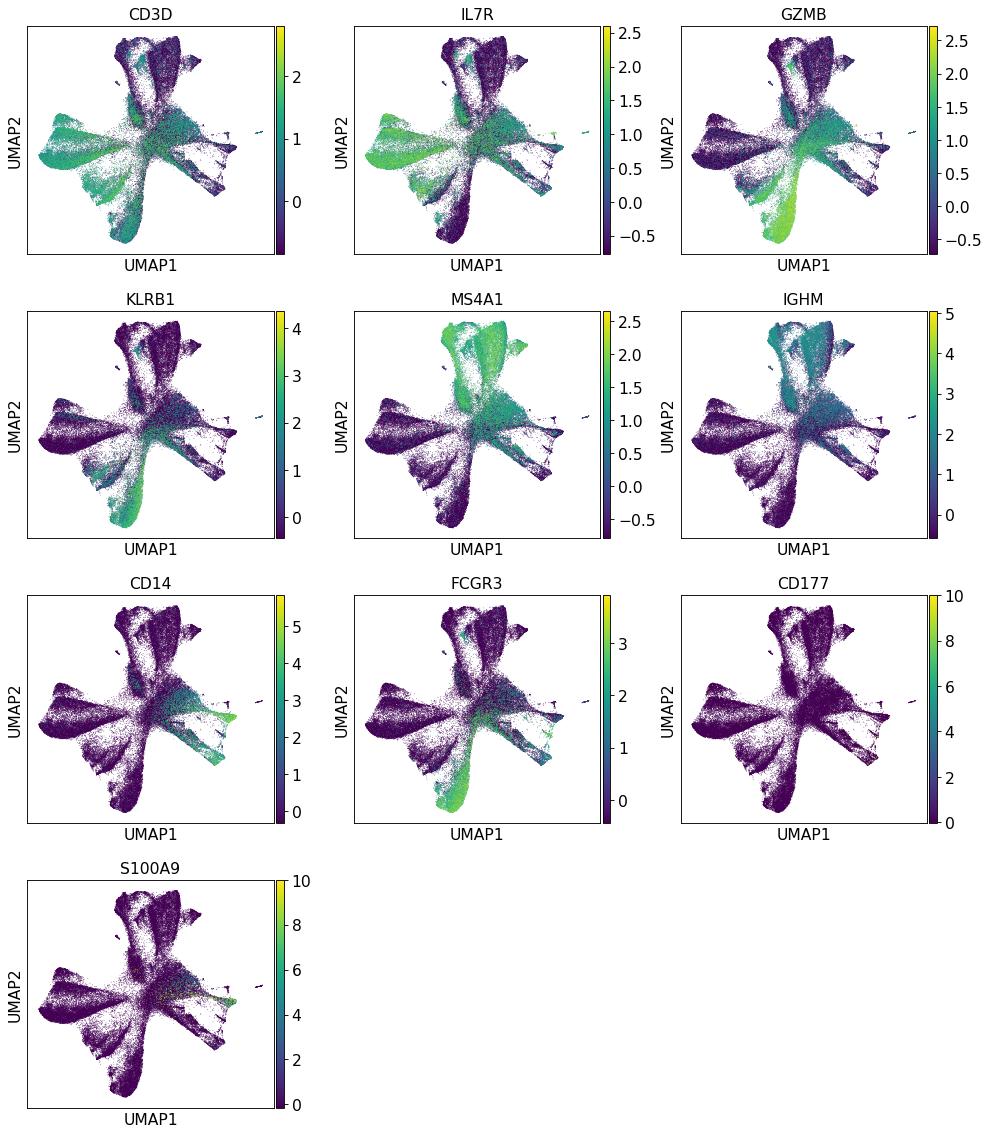

In [52]:
sc.pl.umap(adata, color=['CD3D', 'IL7R', 'GZMB', 'KLRB1', 'MS4A1', 'IGHM', 'CD14', 'FCGR3', 'CD177', 'S100A9'], ncols=3,
          use_raw=False)

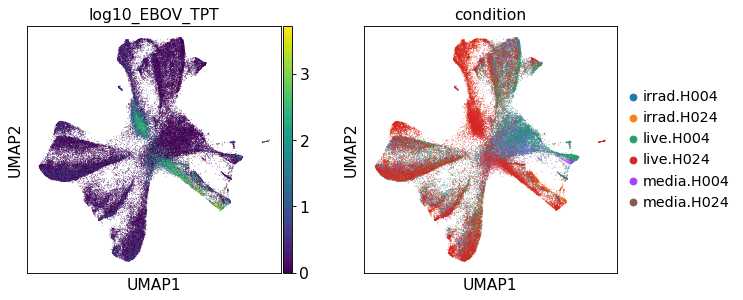

In [53]:
sc.pl.umap(adata, color=['log10_EBOV_TPT', 'condition'], ncols=3)

In [54]:
adata

AnnData object with n_obs × n_vars = 78058 × 16456 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'sample_colors', 'condition_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [55]:
sc.tl.leiden(adata, random_state=14, resolution=1.2)

running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:10:08)


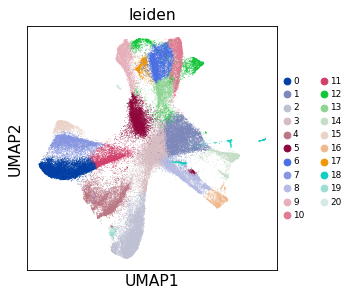

In [56]:
sc.pl.umap(adata, color=['leiden'], legend_fontsize=8)

In [57]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:10)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,CA6,HBB,GZMB,HBB,CD3D,IGKC,CD79B,SPOCK2,LYZ,MX2,...,CA6,HSP90AB1,MS4A1,PSAP,GIMAP7,CTSB,MS4A1,TXN,GNLY,ENSMMUG00000002764
1,PECAM1,IL1B,GNLY,GZMB,ENSMMUG00000038528,ISG15,MS4A1,IL7R,CTSB,MS4A1,...,IL7R,SWAP70,CD79B,IL1B,MX1,PSAP,RPS11,RAMP1,GZMB,JCHAIN
2,IL7R,IGKC,FCGR3,GNLY,CD2,MX1,IGHM,TPT1,LIPA,MX1,...,LEF1,FCRL5,CD19,SOD2,ENSMMUG00000013257,LYZ,RPS27A,MARCKS,TPT1,MZB1
3,SELL,MAMU-DRA,GZMH,GZMH,PTPRC,MX2,SWAP70,ITM2A,PSAP,HERC5,...,ITGA6,CD83,IGHM,CTSB,GIMAP8,FTL,DDX5,CD83,HOPX,HSP90B1
4,TCF7,SOD2,HOPX,KLRB1,SORL1,MS4A1,CD19,VIM,APOE,SWAP70,...,PECAM1,NIN,SWAP70,CFD,ISG15,LIPA,RPL35,HMGN3,FCGR3,ENSMMUG00000038560
5,ITGA6,GZMB,KLRB1,PPBP,TGFBR3,IFIT1,CD79A,CD3D,TXN,CD79B,...,TCF7,MS4A1,IGKC,LYZ,RNF213,FTH1,ENSMMUG00000003867,SEC61B,GZMH,PDIA4
6,LEF1,IFI30,GZMA,ENSMMUG00000042057,ITGA4,MAMU-DRA,MAMU-DRA,GIMAP7,FTL,MAMU-DRA,...,RGS10,IRF4,HHEX,MNDA,IL7R,CYBB,RPL17,ACTG1,ENSMMUG00000014256,HSPA5
7,TPT1,CFD,ENSMMUG00000042057,PF4,PRKCH,EBOV-GP,MAMU-DPA,GIMAP8,LGALS3,XAF1,...,GAL3ST4,TCF4,MEF2C,NFKBIA,KCNA3,LGALS3,RPL13A,BCL2A1,RPS14,PDIA6
8,RPS14,LYZ,IL2RB,GZMA,ZBTB38,HBB,SYK,CREM,FTH1,BANK1,...,RFLNB,BASP1,TCF4,FTH1,HERC6,SAT1,RPS6,CXCL16,RPL13A,IRF4
9,GIMAP7,CYP1B1,KLRC3,PF4V1,ZAP70,IFI27,MAMU-DPB,SORL1,EBOV-GP,IFI16,...,CD3D,ZFP36L1,SMC6,IDO1,OAS2,VIM,RPS5,ACTB,RPL11,SUB1


In [58]:
adata.obs['leiden'].value_counts()

0     8303
1     8244
2     7773
3     6782
4     5694
5     5602
6     4946
7     4510
8     3920
9     3457
10    3284
11    3138
12    2743
13    2437
14    1889
15    1474
16    1380
17    1102
18     753
19     360
20     267
Name: leiden, dtype: int64

In [59]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.HVGs_{nhvgs}.scale.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
results_file

'../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.HVGs_None.scale.h5ad'

In [60]:
save_adata(adata, results_file, gcs=gcs)

Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].


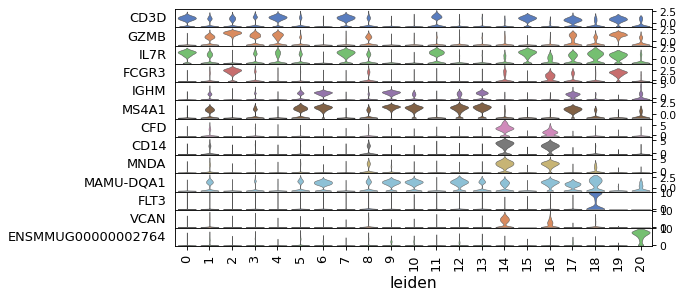

In [61]:
_ = sc.pl.stacked_violin(adata, var_names=['CD3D', 'GZMB', 'IL7R', 'FCGR3', 'IGHM', 'MS4A1', 'CFD', 'CD14', 'MNDA', 'MAMU-DQA1', 'FLT3', 'VCAN', 'ENSMMUG00000002764'], 
                     groupby='leiden', rotation=90, swap_axes=True, use_raw=False)

In [62]:
mapping1 = {'0':'Th 1', '1':'Multiplet 1', '2':'NK 1', '3':'Multiplet 2', '4':'Tc 1', 
            '5':'Multiplet 3', '6':'B 1', '7':'Th 3', '8':'Multiplet 4', '9':'B 2', '10':'B 3',
            '11':'Th 4', '12':'B 4', '13':'B 5', '14':'Mono/DC 1', '15':'Th 5',
           '16':'Mono/DC 2', '17':'Multiplet 5', '18':'Mono/DC 3', '19':'NK 2', '20':'Plasmablast'}
adata.obs['leiden_lab'] = adata.obs['leiden'].replace(mapping1)

adata.obs['leiden_lab_group'] = adata.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])
adata.obs.head()

,batch,array_id,run,BP,treatment_full,treatment,MOI,animal,hour,condition,...,num_EBOV_genes,percent_EBOV,EBOV_TPT,log10_EBOV_TPT,percent_mito,PCT_UNUSABLE_BASES,percent_hbb,leiden,leiden_lab,leiden_lab_group
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0,0.0,0.0,0.0,0.020861,0.493604,0.000000,14,Mono/DC 1,Mono/DC
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAGGTGTA,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0,0.0,0.0,0.0,0.086068,0.514218,0.011765,1,Multiplet 1,Multiplet
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAGCCCAGC,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0,0.0,0.0,0.0,0.003322,0.553940,0.000000,1,Multiplet 1,Multiplet
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACAACATTT,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0,0.0,0.0,0.0,0.074018,0.505076,0.006798,1,Multiplet 1,Multiplet
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACGCTCACG,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_...,EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1,Novaseq_20190829,88,irrad-moi1e-1,irrad,0.1,EV0003,H004,irrad.H004,...,0,0.0,0.0,0.0,0.026007,0.428679,0.005872,1,Multiplet 1,Multiplet


... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


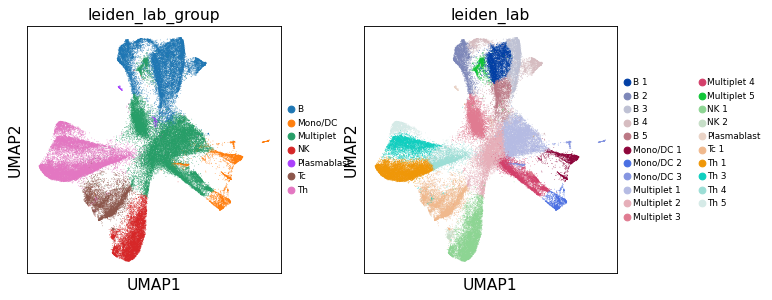

In [63]:
sc.pl.umap(adata, color=['leiden_lab_group','leiden_lab'], legend_fontsize=8)

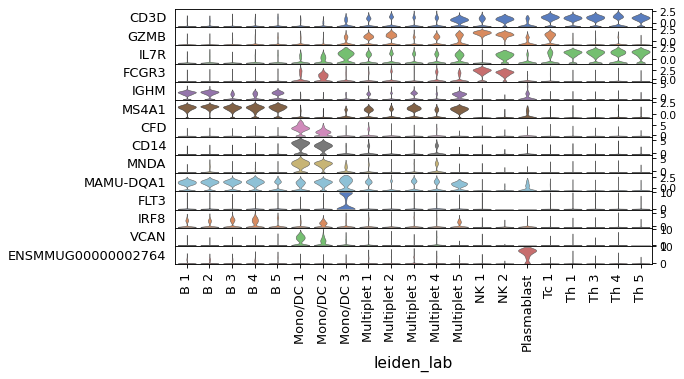

In [64]:
_ = sc.pl.stacked_violin(adata, var_names=['CD3D', 'GZMB', 'IL7R', 'FCGR3', 'IGHM', 'MS4A1', 'CFD', 'CD14', 'MNDA', 'MAMU-DQA1', 'FLT3', 'IRF8', 'VCAN', 'ENSMMUG00000002764'], 
                     groupby='leiden_lab', rotation=90, swap_axes=True, use_raw=False)

In [65]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
results_file

'../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.h5ad'

In [66]:
adata

AnnData object with n_obs × n_vars = 78058 × 16456 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden', 'leiden_lab', 'leiden_lab_group'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'sample_colors', 'condition_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'leiden_lab_group_colors', 'leiden_lab_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [67]:
adata.obs.loc[:, 'Subclustering'] = np.nan
adata.obs.loc[:, 'SubclusteringGroup'] = np.nan
adata.obs.loc[:, 'Doublet'] = False

In [68]:
save_adata(adata, results_file, gcs=gcs)

Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].


In [69]:
adata = read_adata(results_file, gcs=gcs)

Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].


## Run subclustering

In [70]:
base_nbcommand = '''jupyter nbconvert --ExecutePreprocessor.allow_errors=True --ExecutePreprocessor.timeout=-1 --ExecutePreprocessor.timeout=-1 \
--FilesWriter.build_directory=../../../results --execute %s'''


In [71]:
! {base_nbcommand % './Subclustering_ExVivo/Subcluster.ExVivo.Myeloid.ipynb'}
! {base_nbcommand % './Subclustering_ExVivo/Subcluster.ExVivo.B.ipynb'}
! {base_nbcommand % './Subclustering_ExVivo/Subcluster.ExVivo.TNK.ipynb'}

[NbConvertApp] Converting notebook ./Subclustering_ExVivo/Subcluster.ExVivo.Myeloid.ipynb to html
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 2999437 bytes to ../../../results/Subcluster.ExVivo.Myeloid.html
[NbConvertApp] Converting notebook ./Subclustering_ExVivo/Subcluster.ExVivo.B.ipynb to html
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 4546833 bytes to ../../../results/Subcluster.ExVivo.B.html
[NbConvertApp] Converting notebook ./Subclustering_ExVivo/Subcluster.ExVivo.TNK.ipynb to html
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 4843695 bytes to ../../../results/Subcluster.ExVivo.TNK.html


## Re-analyze after sub-clustering

In [72]:
annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
annot_file

'../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.SubclusterMBTNK.h5ad'

In [73]:
adata = read_adata(annot_file, gcs=gcs)

Only considering the two last: ['.SubclusterMBTNK', '.h5ad'].
Only considering the two last: ['.SubclusterMBTNK', '.h5ad'].


In [74]:
pd.crosstab(adata.obs['leiden_lab_group'], [adata.obs['Doublet'], adata.obs['SubclusteringGroup']])

Doublet               False                                                   \
SubclusteringGroup B_Memory B_Naive  Mono    NK Plasmablast    Tc Th_CXCR5hi   
leiden_lab_group                                                               
B                     11952    3724     0     0           7     0          0   
Mono/DC                   0       0  2606     0           0     0          0   
Multiplet                 0       0     0     0           0     0          0   
NK                        0       0     0  7679           0   215          5   
Plasmablast              12       0     0     0         252     0          0   
Tc                        0       0     0   249           0  4836        238   
Th                        0       0     0    23           0   178        252   

Doublet                                                                     \
SubclusteringGroup Th_ITGB1hi_SELLlo Th_ITGB1lo_SELLhi Th_ITGB1mid_SELLmid   
leiden_lab_group                                                             
B                                  0                 0                   0   
Mono/DC                            0                 0                   0   
Multiplet                          0                 0                   0   
NK                                 7                 0                   2   
Plasmablast                        0                 0                   0   
Tc                                96                24                  28   
Th                              5100              8629                1960   

Doublet                              True  
SubclusteringGroup Treg  cDC    nan   nan  
leiden_lab_group                           
B                     0    0      0  1184  
Mono/DC               0  406      0  1010  
Multiplet             0    0  25650     0  
NK                    0    0      0   225  
Plasmablast           0    0      0     3  
Tc                    0    0      0   223  
Th                  241    0      0  1042

In [75]:
adata = adata[adata.obs['SubclusteringGroup']!='nan',:]

In [76]:
adata.obs['SubclusteringGroup'].value_counts()

B_Memory               11964
Th_ITGB1lo_SELLhi       8653
NK                      7951
Tc                      5229
Th_ITGB1hi_SELLlo       5203
B_Naive                 3724
Mono                    2606
Th_ITGB1mid_SELLmid     1990
Th_CXCR5hi               495
cDC                      406
Plasmablast              259
Treg                     241
Name: SubclusteringGroup, dtype: int64

In [77]:
adata = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)


In [78]:
adata.raw = adata.copy()

In [79]:
tokeep = (~adata.var['Combined_Blacklist'])

In [80]:
adata = adata[:, tokeep]

In [81]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=nhvgs)
adata.var['highly_variable'].value_counts()

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


False    14297
True      2252
Name: highly_variable, dtype: int64

In [82]:
sc.pp.scale(adata, max_value=10)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:06)


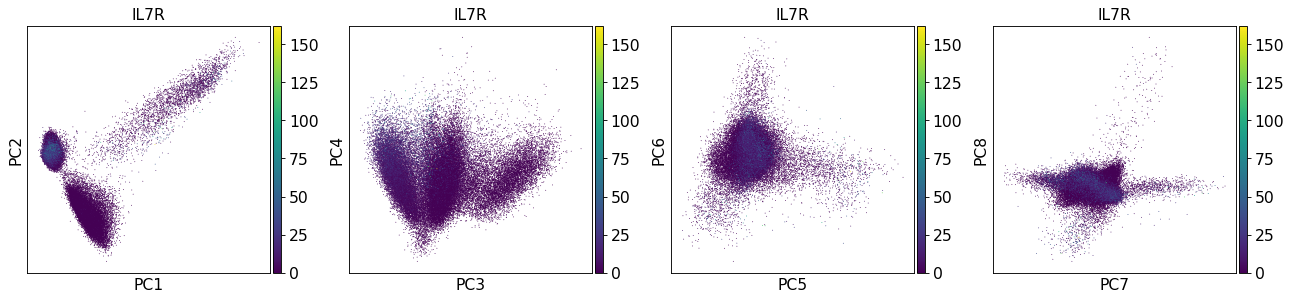

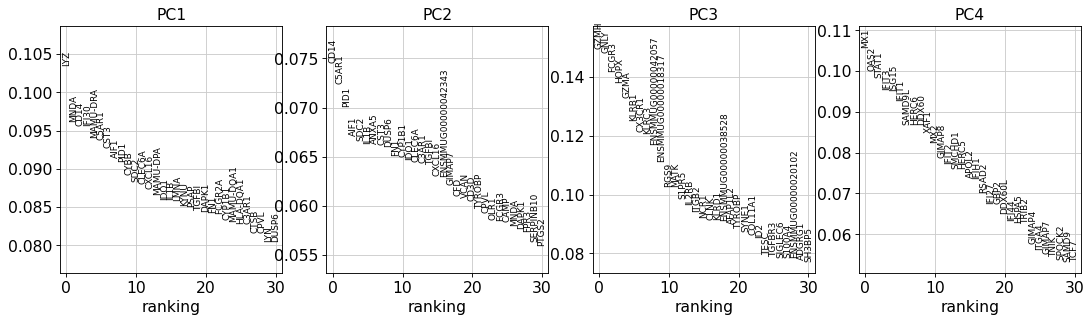

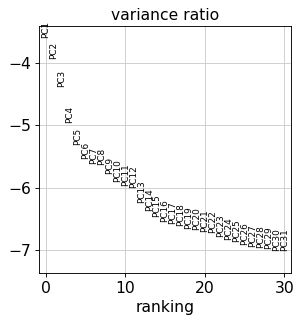

In [83]:
sc.tl.pca(adata, svd_solver='arpack', random_state=14, use_highly_variable=True)

sc.pl.pca(adata, components=['1,2', '3,4', '5,6', '7,8'], color=['IL7R'],
          ncols=4, use_raw=True)

sc.pl.pca_loadings(adata, components=[1,2,3,4])

sc.pl.pca_variance_ratio(adata, log=True)


In [84]:
adata

AnnData object with n_obs × n_vars = 48721 × 16549 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden', 'leiden_lab', 'leiden_lab_group', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [85]:
sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.001), n_pcs=16, random_state=14)
    
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=14)

computing neighbors
    using 'X_pca' with n_pcs = 16


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:42)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:42)


In [86]:
adata

AnnData object with n_obs × n_vars = 48721 × 16549 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden', 'leiden_lab', 'leiden_lab_group', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

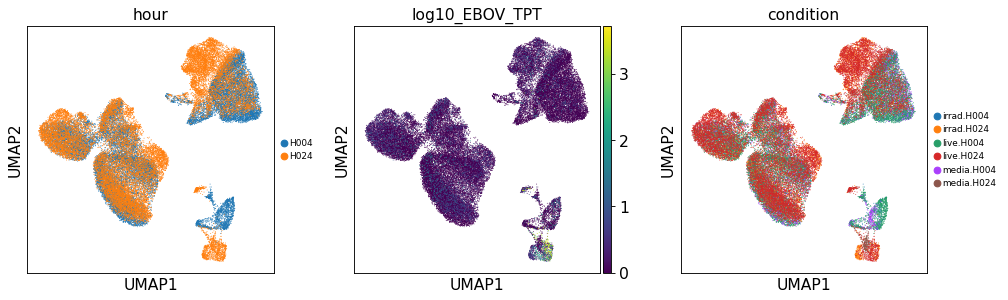

In [87]:
sc.pl.umap(adata, color=['hour', 'log10_EBOV_TPT', 'condition'], legend_fontsize=8)

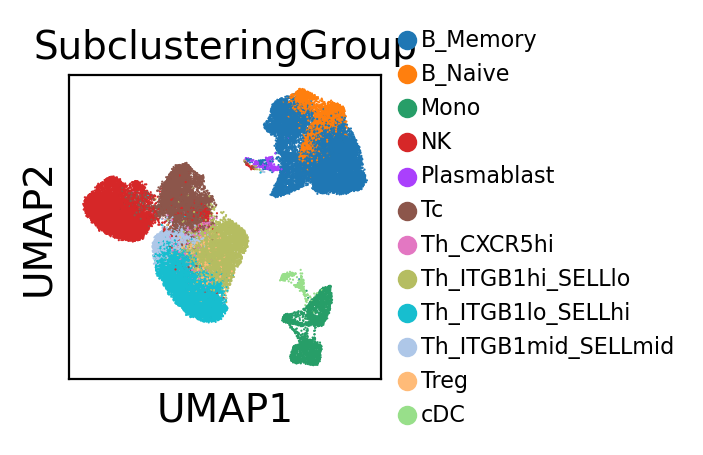

In [88]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)
sc.pl.umap(adata, color=['SubclusteringGroup'], ax=ax, legend_fontsize=8)

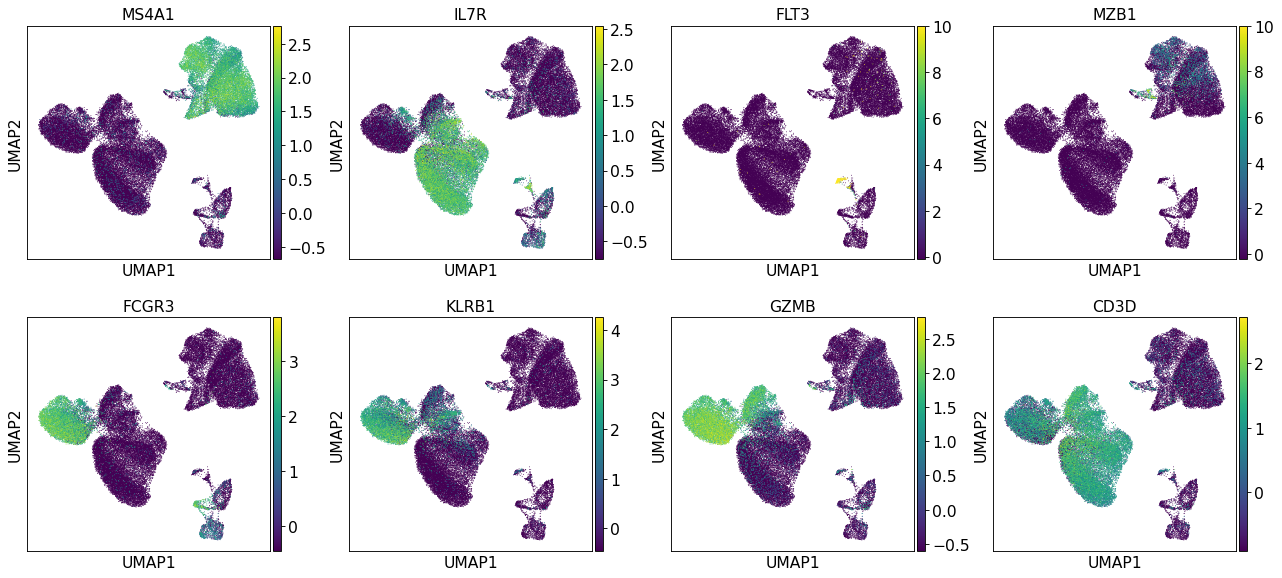

In [89]:
sc.pl.umap(adata, color=['MS4A1', 'IL7R', 'FLT3', 'MZB1', 'FCGR3', 'KLRB1', 'GZMB', 'CD3D'], use_raw=False)

In [90]:
sc.tl.rank_genes_groups(adata, groupby='SubclusteringGroup')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:20)


In [91]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

,B_Memory,B_Naive,Mono,NK,Plasmablast,Tc,Th_CXCR5hi,Th_ITGB1hi_SELLlo,Th_ITGB1lo_SELLhi,Th_ITGB1mid_SELLmid,Treg,cDC
0,MS4A1,CD79B,MNDA,GZMB,REXO2,TGFBR3,TMEM155,ITM2A,CA6,DUSP27,IL2RA,SRI
1,CD19,SELL,CASP1,HOPX,SUB1,ENSMMUG00000038528,GPR183,GIMAP7,LEF1,CHRM3,CA6,MARCKS
2,SWAP70,AGBL2,PSAP,GZMH,ENSMMUG00000038560,CD3D,PRDM8,ICOS,PECAM1,GALNT9,RTKN2,RAMP1
3,BANK1,CSNK1G3,AIF1,FCGR3,PDIA4,CLIC5,TCF7,SPOCK2,ITGA6,SPRY3,SOS1,SUB1
4,CD79B,OSBPL8,SOD2,GNLY,JCHAIN,CD2,DNASE1L3,BICDL1,RFLNB,HOXC10,PCED1B,SYNGR2
5,SMC6,GPR155,NFKBIA,KLRB1,HSP90B1,GZMK,MYB,TPT1,SELL,ENSMMUG00000032525,MYO5C,RALA
6,WDFY4,PLEKHA2,DNAJC25,ENSMMUG00000042057,ENSMMUG00000005314,CCR5,MYO6,IL7R,TCF7,ARHGEF15,MYB,ACTG1
7,HHEX,CD19,C3AR1,KLRC3,SPATS2,DNAJC1,CD3D,DUSP16,TMEM63A,IGSF9B,FOXP3,ENSMMUG00000014256
8,DST,RPS27A,DAPK1,GZMA,SPCS1,ADAM23,FAM184B,CREM,RGS10,ENSMMUG00000045284,INPP4B,BCL2A1
9,TLR10,CD79A,PID1,IL2RB,MZB1,ZBTB38,FAM84B,CD3D,IL7R,CFHR5,GIPC2,CCDC88A


In [92]:
pd.crosstab(adata.obs['leiden_lab'], [adata.obs['SubclusteringGroup'], adata.obs['Doublet']])

SubclusteringGroup,B_Memory,B_Naive,Mono,NK,Plasmablast,Tc,Th_CXCR5hi,Th_ITGB1hi_SELLlo,Th_ITGB1lo_SELLhi,Th_ITGB1mid_SELLmid,Treg,cDC
Doublet,False,False,False,False,False,False,False,False,False,False,False,False
leiden_lab,,,,,,,,,,,,
B 1,2790,2004,0,0,2,0,0,0,0,0,0,0
B 2,2540,658,0,0,0,0,0,0,0,0,0,0
B 3,3140,1,0,0,0,0,0,0,0,0,0,0
B 4,2380,11,0,0,4,0,0,0,0,0,0,0
B 5,1102,1050,0,0,1,0,0,0,0,0,0,0
Mono/DC 1,0,0,1491,0,0,0,0,0,0,0,0,10
Mono/DC 2,0,0,1113,0,0,0,0,0,0,0,0,1
Mono/DC 3,0,0,2,0,0,0,0,0,0,0,0,395


In [93]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
results_file

'../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.SubclusterMBTNK.UMAP.h5ad'

In [94]:
save_adata(adata, results_file, gcs=gcs)

Only considering the two last: ['.UMAP', '.h5ad'].
Only considering the two last: ['.UMAP', '.h5ad'].


In [95]:
adata = read_adata(results_file, gcs=gcs)

Only considering the two last: ['.UMAP', '.h5ad'].
Only considering the two last: ['.UMAP', '.h5ad'].


## Run infection inference

In [96]:
nbcommand = '''jupyter nbconvert --ExecutePreprocessor.allow_errors=True --ExecutePreprocessor.timeout=-1 --ExecutePreprocessor.timeout=-1 \
--FilesWriter.build_directory=../../../results --execute Detect_Infected_Cells_ExVivo.ipynb'''
print(nbcommand)
!{nbcommand}

jupyter nbconvert --ExecutePreprocessor.allow_errors=True --ExecutePreprocessor.timeout=-1 --ExecutePreprocessor.timeout=-1 --FilesWriter.build_directory=../../../results --execute Detect_Infected_Cells_ExVivo.ipynb
[NbConvertApp] Converting notebook Detect_Infected_Cells_ExVivo.ipynb to html
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 2493753 bytes to ../../../results/Detect_Infected_Cells_ExVivo.html


In [97]:
results_with_ebov_fn = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_with_ebov_fn)

../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad


In [98]:
adata = read_adata(results_with_ebov_fn, gcs=gcs)

Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].


## Make UMAP plots

In [99]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

In [100]:
adata.obs.columns

Index(['batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI',
       'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes',
       'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts',
       'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT',
       'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden',
       'leiden_lab', 'leiden_lab_group', 'Subclustering', 'SubclusteringGroup',
       'Doublet', 'Soup_Usage', 'ebola_infection_threshold', 'Ebola_Positive'],
      dtype='object')

In [101]:
cols = ['batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI',
       'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes',
       'log_count','log10_EBOV_TPT', 'EBOV_counts', 'percent_EBOV',
        'Subclustering', 'SubclusteringGroup',
        'Ebola_Positive']

umapdata = adata.obs[cols]
umapdata['UMAP_1'] = adata.obsm['X_umap'][:,0]
umapdata['UMAP_2'] = adata.obsm['X_umap'][:,1]

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [102]:
list(umapdata['SubclusteringGroup'].unique())

['Mono',
 'Th_ITGB1lo_SELLhi',
 'Th_CXCR5hi',
 'B_Naive',
 'B_Memory',
 'Th_ITGB1hi_SELLlo',
 'Tc',
 'NK',
 'cDC',
 'Plasmablast',
 'Th_ITGB1mid_SELLmid',
 'Treg']

In [103]:
repmap = {'Mono':'Monocyte',
          'Th_ITGB1mid_SELLmid':'T CD4+ ITGB1mid SELLmid',
          'B_Naive':'B Naive',
          'B_Memory':'B Memory',
          'Th_ITGB1hi_SELLlo':'T CD4+ ITGB1hi SELLlo',
          'Tc':'T CD8+',
          'Th_ITGB1lo_SELLhi':'T CD4+ ITGB1lo SELLhi',
          'Th_CXCR5hi':'T CD4+ CXCR5hi',
          'Treg':'Treg',
          'NK':'NK',
          'cDC':'cDC',
          'Plasmablast':'Plasmablast'}
umapdata['Subclustering_clean'] = umapdata['SubclusteringGroup'].replace(repmap)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [104]:
umapdata['MX1'] = adata.obs_vector('MX1')

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


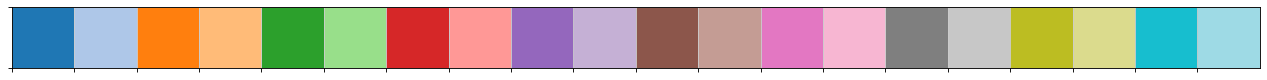

In [105]:
cmap = plt.get_cmap('Set1')
clustering = np.unique(umapdata['Subclustering_clean'])
c = palettable.tableau.Tableau_20.hex_colors
sns.palplot(c)

In [106]:

colors = {'B Naive':c[0], 
          'B Memory':c[1],
          'T CD4+ ITGB1hi SELLlo':c[2],
          'T CD4+ ITGB1mid SELLmid':c[16],
          'T CD4+ ITGB1lo SELLhi':'#FCCE03',
          'Treg':c[3],
          'T CD4+ CXCR5hi':c[7],
          'T CD8+':c[6],
          'NK':c[10], 
          'Monocyte':c[4], 'cDC':c[5], 'Plasmablast':c[19]}
umapdata['cluster_color'] = umapdata['Subclustering_clean'].apply(lambda x: colors[x])

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [107]:
box_height=1.7
box_width=1.7
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


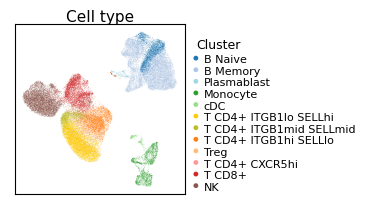

In [108]:
leg_width=1.1
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'], c=umapdata['cluster_color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.1

clustering = ['B Naive', 'B Memory', 'Plasmablast',
                       'Monocyte','cDC',
                      'T CD4+ ITGB1lo SELLhi',
                      'T CD4+ ITGB1mid SELLmid',
                      'T CD4+ ITGB1hi SELLlo',
                      'Treg',
                      'T CD4+ CXCR5hi',
                      'T CD8+','NK']

for (i,y) in zip(clustering[::-1], np.linspace(0.05, 0.8, len(clustering))):
  legend_ax.scatter(marker_x, y, color=colors[i], s=12, edgecolor='None')
  legend_ax.text(marker_x+.07, y-.025, i, fontsize=8)
legend_ax.text(.1, .86, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Cell type', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)


figure_file = os.path.join(results_dir, "UMAP.Seqwell.Exvivo.Celltype.pdf")
fig.savefig(figure_file, dpi=400)

In [109]:
cset = palettable.tableau.GreenOrange_12.hex_colors

condition_cmap = {'live.H024':cset[2], 'live.H004':cset[3], 'irrad.H024':cset[4],  'irrad.H004':cset[5], 'media.H024':cset[0], 'media.H004':cset[1]}
umapdata['condition_color'] = umapdata['condition'].apply(lambda x: condition_cmap[x])

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


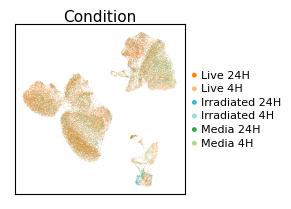

In [110]:
leg_width=.95
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'], c=umapdata['condition_color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.1

clustering = ['live.H024', 'live.H004', 'irrad.H024',  'irrad.H004', 'media.H024', 'media.H004']
relabmap = {'live.H024':'Live 24H', 'live.H004':'Live 4H', 'irrad.H004':'Irradiated 4H',
 'irrad.H024':'Irradiated 24H', 'media.H004':'Media 4H', 'media.H024':'Media 24H'}

for (i,y) in zip(clustering[::-1], np.linspace(0.3, 0.7, len(clustering))):
  legend_ax.scatter(marker_x, y, color=condition_cmap[i], s=12, edgecolor='None')
  legend_ax.text(marker_x+.07, y-.015, relabmap[i], fontsize=8)
#legend_ax.text(.1, .8, 'Cell type', fontsize=7)

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Condition', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Exvivo.Condition.pdf")
fig.savefig(figure_file, dpi=400)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


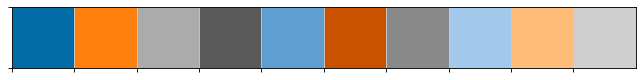

In [111]:
cset = palettable.tableau.ColorBlind_10.hex_colors
sns.palplot(cset)
animal_cmap = {'EV0003':cset[4], 'EV0004':cset[5]}
umapdata['animal_color'] = umapdata['animal'].apply(lambda x: animal_cmap[x])

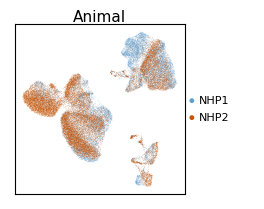

In [112]:
leg_width=.7
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'], c=umapdata['animal_color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)


legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.1

clustering = np.array(['EV0003', 'EV0004'])

num = 2
for (i,y) in zip(clustering[::-1], np.linspace(0.45, 0.55, len(clustering))):
  legend_ax.scatter(marker_x, y, color=animal_cmap[i], s=12, edgecolor='None')
  legend_ax.text(marker_x+.1, y-.015, 'NHP'+str(num), fontsize=8)
  num-=1
#legend_ax.text(.1, .8, 'Cell type', fontsize=7)

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Animal', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Exvivo.Animal.pdf")
fig.savefig(figure_file, dpi=400)

In [113]:
umapdata['log10_EBOV_TPT_Clean'] = umapdata['log10_EBOV_TPT'].copy()
umapdata.loc[umapdata['Ebola_Positive']==False, 'log10_EBOV_TPT_Clean']=0

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


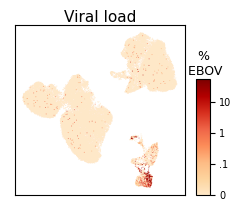

In [114]:
leg_width=.5
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
ebov_cmap = LinearSegmentedColormap.from_list(name='ebov_cmap', N=1000,
                                              colors=palettable.colorbrewer.sequential.OrRd_9.mpl_colors[1:])

umapdata_sorted = umapdata.sort_values(by='log10_EBOV_TPT_Clean', ascending=True)
markersize = .5
cbarim = ax.scatter(umapdata_sorted['UMAP_1'], umapdata_sorted['UMAP_2'], 
           c=umapdata_sorted['log10_EBOV_TPT_Clean'],
           s=markersize, alpha=.7, edgecolor='None', rasterized=True, cmap=ebov_cmap)


cbar_ax = fig.add_axes([.81, .02, .06, .6])

fig.colorbar(cbarim, cax=cbar_ax, ticks=[0, 1, 2, 3])

cbar_ax.set_yticklabels(['0', '.1', '1', '10'])
#cbar_ax.set_title('% EBOV')
plt.figtext(.84, .7, '%\n EBOV', fontsize=9, va='center', ha='center')

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1, 'Viral load', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Exvivo.EbolaPercent.pdf")
fig.savefig(figure_file, dpi=400)

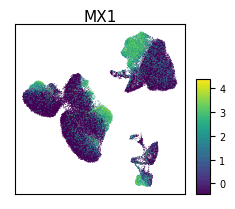

In [115]:
leg_width=.5
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
gene_cmap = 'viridis'
g = 'MX1'

umapdata_sorted = umapdata.sort_values(by=g, ascending=True)
markersize = .5
cbarim = ax.scatter(umapdata_sorted['UMAP_1'], umapdata_sorted['UMAP_2'], 
           c=umapdata_sorted[g],
           s=markersize, alpha=.7, edgecolor='None', rasterized=True,
           cmap=gene_cmap)


cbar_ax = fig.add_axes([.81, .02, .06, .6])

fig.colorbar(cbarim, cax=cbar_ax, ticks=[0, 1, 2, 3, 4, 5])

cbar_ax.set_yticklabels(['0', '1', '2', '3', '4', '5'])
#cbar_ax.set_title('% EBOV')
#plt.figtext(.885, .7, '% EBOV', fontsize=9, va='center', ha='center')

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, g, va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Exvivo.MX1.pdf")
fig.savefig(figure_file, dpi=400)


## Get ISG score

In [116]:
ISG_fn = '../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.ISGs.txt'
interferon_set = open(ISG_fn).read().split('\n')

In [117]:
adata_for_ifn_score = sc.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
adata_for_ifn_score = adata_for_ifn_score[:,~adata_for_ifn_score.var['Combined_Blacklist']]
sc.pp.filter_genes(adata_for_ifn_score, min_cells=10)
sc.pp.normalize_per_cell(adata_for_ifn_score, counts_per_cell_after=10000)
sc.pp.log1p(adata_for_ifn_score)

filtered out 945 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [118]:
sc.tl.score_genes(adata_for_ifn_score, gene_list=interferon_set, ctrl_size=len(interferon_set), score_name='ifn_score')

computing score 'ifn_score'
    finished: added
    'ifn_score', score of gene set (adata.obs) (0:00:08)


In [119]:
umapdata['ifn_score'] = adata_for_ifn_score.obs.loc[umapdata.index, 'ifn_score']

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'ifn_score')

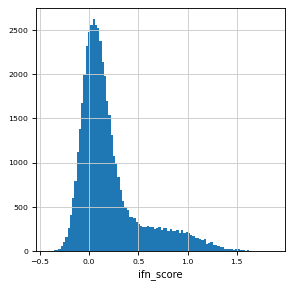

In [120]:
_ = plt.hist(umapdata['ifn_score'], bins=100)
plt.xlabel('ifn_score')

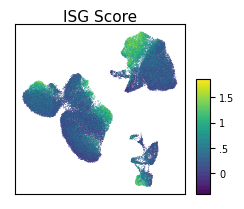

In [121]:
leg_width=.5
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
gene_cmap = 'viridis'
g = 'ifn_score'

umapdata_sorted = umapdata.sort_values(by=g, ascending=True)
markersize = .5
cbarim = ax.scatter(umapdata_sorted['UMAP_1'], umapdata_sorted['UMAP_2'], 
           c=umapdata_sorted[g],
           s=markersize, alpha=.7, edgecolor='None', rasterized=True,
           cmap=gene_cmap)


cbar_ax = fig.add_axes([.81, .02, .06, .6])

fig.colorbar(cbarim, cax=cbar_ax, ticks=[-1, -.5, 0, .5, 1, 1.5, 2])

cbar_ax.set_yticklabels(['-1', '-.5', '0', '.5', '1', '1.5', '2'])
#cbar_ax.set_title('% EBOV')
#plt.figtext(.885, .7, '% EBOV', fontsize=9, va='center', ha='center')

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'ISG Score', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Seqwell.Exvivo.ISGscore.pdf")
fig.savefig(figure_file, dpi=400)

In [122]:
umap_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.UMAPdata.tsv'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
umapdata.to_csv(umap_file, sep='\t')

In [123]:
umapdata['condition_clean'] = umapdata['condition'].replace(relabmap).apply(lambda x: x.replace('Irradiated', 'Irrad.'))

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
umapdata['animal_clean'] = umapdata['animal'].replace({'EV0003':'NHP1', 'EV0004':'NHP2'})

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


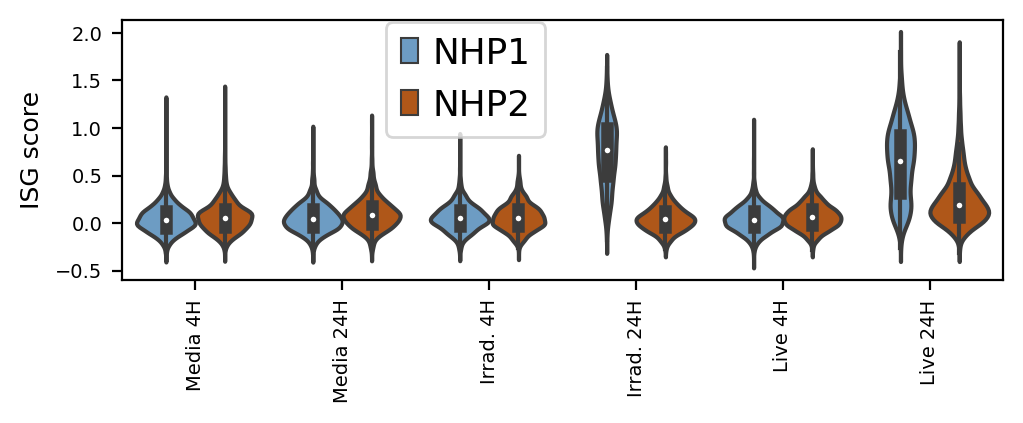

In [125]:
fig = plt.figure(constrained_layout=True, figsize=(5,2), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.98, top=.98)
ax = fig.add_subplot(gs[0])

cset = palettable.tableau.ColorBlind_10.hex_colors

animal_cmap = {'NHP1':cset[4], 'NHP2':cset[5]}

labels = ['Media 4H', 'Media 24H', 'Irrad. 4H', 'Irrad. 24H', 'Live 4H', 'Live 24H']

sns.violinplot(x='condition_clean', hue='animal_clean', y='ifn_score',
               data=umapdata, ax=ax, order=labels, palette=animal_cmap)
ax.set_xticklabels(labels, rotation=90)
ax.legend(loc=(.3,.55))
ax.set_ylabel('ISG score')
ax.set_xlabel('')
ax.grid(False)

figure_file = os.path.join(results_dir, "ISGscore.ExVivo.PerCondition.Violin.pdf")
fig.savefig(figure_file, dpi=400)